In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/shapes'

In [4]:
data_transforms = transforms.Compose([transforms.ToTensor(), # 우선 텐서로 바꿔주고
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 정규화

In [5]:
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
class_names = full_dataset.classes

In [6]:
# Hyper-Parameter
batch_size= 16
max_pool_kernel = 2
learning_rate = 0.0001
num_epochs = 50

In [7]:
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
valid_dataset[0][0].shape

torch.Size([3, 28, 28])

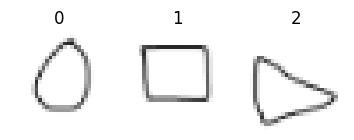

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,10))
target = 0
for i in range(200):
  image = valid_dataset[i][0]
  label = valid_dataset[i][1]
  if target == 3: break
  if label == target:
    image = torchvision.utils.make_grid(image)
    image = image / 2 + 0.5     # unnormalize
    npimg = image.numpy()

    plt.subplot(1, 10, target+1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.axis('off')
    target += 1

plt.show()

In [11]:
import torch.nn.functional as F
import torchsummary as summary # optional, to see model's summary

class ConvNet(nn.Module):
  def __init__(self, num_classes):
    super(ConvNet, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(max_pool_kernel)
    )
    self.fc1 = nn.Linear(7*7*128, 120)
    self.fc2 = nn.Linear(120, 30)
    self.fc3 = nn.Linear(30, num_classes)

    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)

    x = x.reshape(x.size(0), -1) # flatten
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.sigmoid(self.fc3(x))
    return x

In [12]:
model = ConvNet(3).to(device)

In [13]:
from torchsummary import summary
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]         204,928
       BatchNorm2d-6          [-1, 128, 14, 14]             256
              ReLU-7          [-1, 128, 14, 14]               0
         MaxPool2d-8            [-1, 128, 7, 7]               0
            Linear-9                  [-1, 120]         752,760
          Dropout-10                  [-1, 120]               0
           Linear-11                   [-1, 30]           3,630
          Dropout-12                   [-1, 30]               0
           Linear-13                    [-1, 3]              93
Total params: 966,659
Trainable params:

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Assign Tensors to Configured Device
    images = images.to(device) # 데이터를 GPU에 올려준다
    labels = labels.to(device)

    outputs = model(images) # model을 통해 예측값 산출

    loss = criterion(outputs, labels)
    optimizer.zero_grad() # gradient를 초기화
    loss.backward() # backward로 gradient 계산
    optimizer.step() # graident update

    loss_list.append(loss.detach().cpu().numpy()) # tensor인 loss를 cpu로 가져와서 numpy로 바꿔서 저장

    if i == 0:
      print("Epoch [{}/{}], Loss: {}".format(epoch + 1, num_epochs, loss))
  torch.save(model.state_dict(), 'model.pth') # pth 파일로 모델, 파라미터 등을 보기 쉽게 저장

Epoch [1/50], Loss: 1.0864051580429077
Epoch [2/50], Loss: 1.0937801599502563
Epoch [3/50], Loss: 1.0417457818984985
Epoch [4/50], Loss: 0.9390372037887573
Epoch [5/50], Loss: 0.8864369988441467
Epoch [6/50], Loss: 0.949173629283905
Epoch [7/50], Loss: 0.837861955165863
Epoch [8/50], Loss: 0.7880043983459473
Epoch [9/50], Loss: 0.7148982286453247
Epoch [10/50], Loss: 0.7545079588890076
Epoch [11/50], Loss: 0.6664798855781555
Epoch [12/50], Loss: 0.6667471528053284
Epoch [13/50], Loss: 0.6287415027618408
Epoch [14/50], Loss: 0.6493704915046692
Epoch [15/50], Loss: 0.6509431600570679
Epoch [16/50], Loss: 0.643131673336029
Epoch [17/50], Loss: 0.7113003134727478
Epoch [18/50], Loss: 0.6312906742095947
Epoch [19/50], Loss: 0.5816735029220581
Epoch [20/50], Loss: 0.616592526435852
Epoch [21/50], Loss: 0.5730457901954651
Epoch [22/50], Loss: 0.6108232736587524
Epoch [23/50], Loss: 0.5623441338539124
Epoch [24/50], Loss: 0.584029495716095
Epoch [25/50], Loss: 0.5903710126876831
Epoch [26/50],

In [15]:
model.eval()
with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    t, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(valid_loader)*batch_size, 100*correct/total))

Accuracy of the network on the 64 test images 93.33333333333333%


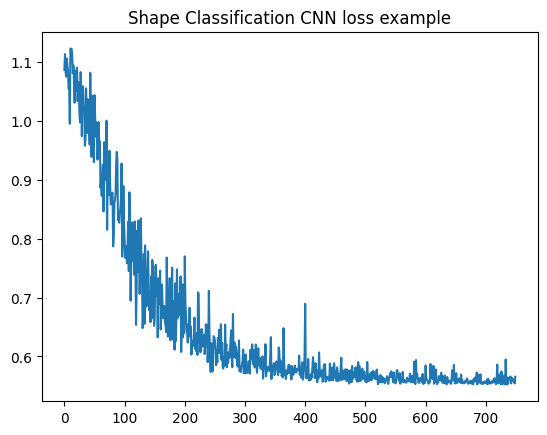

In [16]:
plt.plot(loss_list)
plt.title("Shape Classification CNN loss example")
plt.show()